# The Discourse API
As we move into linear algebra, it'll be nice to access, live, large, *actual* datasets. We've got a fun example coming up involving eigenvalues of a matrix generated by scraping data off of the web, in fact. What could be better?

For the time being, let's ease into data wrangling by interfacing with Discourse to see how we're doing there.  Discourse, of course, is *first* a website.  Check out the following two pages:

<ul>
    <li><a href="http://discourse.marksmath.org/categories">http://discourse.marksmath.org/categories</a></li>
    <li><a href="http://discourse.marksmath.org/categories.json">http://discourse.marksmath.org/categories.json</a></li>
</ul>

The first is just a pretty standard webpage on discourse, though you might not have looked at it before. The second contains the same information, but formatted as [JSON](https://en.wikipedia.org/wiki/JSON). That highly structed format allows us to manipulate it with a computer quite easily. For example, here is the list of categories currently on our Discourse.

In [1]:
import requests
response = requests.get("http://discourse.marksmath.org/categories.json")
if response.status_code == 200:
    response_json = response.json()
    print([category['name'] for category in response_json['category_list']['categories']])
else:
    print("Uh-oh")

['Numerical', 'Real', 'Analysis', 'Meta']


There's a couple of things going on here. First, the [Requests Library](http://docs.python-requests.org/en/master/) (standard with Anaconda) is a great library for grabbing information off of the web. That's exactly what the `requests.get()` command did. Second, the `response.json()` command transformed the result into a Python dictionary, which JSON very closely resembles. You should probably [refresh yourself on Python dictionaries](https://docs.python.org/3.5/tutorial/datastructures.html#dictionaries), if you want to follow this well.

The corresponding category IDs, which are used in URLs, are:

In [2]:
[category['id'] for category in response_json['category_list']['categories']]

[6, 7, 10, 9]

So, we can dig further now into the Numerical category (with `id=6`) and look at the list of topics as follows:

In [3]:
response = requests.get("http://discourse.marksmath.org/c/6.json")
response_json = response.json()
topic_titles = [topic['title'] for topic in response_json['topic_list']['topics']]
topic_titles

['About the Numerical category',
 'Exam Review',
 'Some problems from chapter 5',
 'Study In Math Lab Tomorrow?',
 'Lets discuss these problems!',
 'Some problems from chapter 6',
 'Interesting Project Euler problem',
 'Quiz problem: A binary expansion',
 'Quiz problem: A Taylor approximation',
 'Quiz problem: Estimate with the integral test',
 'Generating a number from a 64 bit string',
 'Your favorite function',
 'A hexadecimal integer',
 'A Taylor approximation',
 'Summing a (binary) expansion',
 "Nice plot of a function together with it's derivative"]

Here they are sorted by popularity according to `like_count`.

In [4]:
import numpy as np
like_counts = [topic['like_count'] for topic in response_json['topic_list']['topics']]
order = np.argsort(like_counts)
sorted_topic_titles = [topic_titles[i] for i in order]
sorted_topic_titles.reverse()
sorted_topic_titles

['Your favorite function',
 'Some problems from chapter 5',
 'Summing a (binary) expansion',
 'A Taylor approximation',
 'Some problems from chapter 6',
 'Quiz problem: Estimate with the integral test',
 'Quiz problem: A binary expansion',
 'Exam Review',
 'A hexadecimal integer',
 'Quiz problem: A Taylor approximation',
 'Generating a number from a 64 bit string',
 'Interesting Project Euler problem',
 'Study In Math Lab Tomorrow?',
 "Nice plot of a function together with it's derivative",
 'Lets discuss these problems!',
 'About the Numerical category']

## Assessing trust levels

Great! But, can we do anything worthwhile with this?  How about we take a look at where folks are when it comes to trust levels. Note that an `api_key` is required for the request that follow, so not just anyone can do it. Altogether, my `api_key_string` has the form:

In [5]:
api_key_string = "api_key=LONG_CRAZY_STRING&api_username=mark"

In [6]:
response = requests.get("http://discourse.marksmath.org/admin/users.json?" + api_key_string)
users_json = response.json()
len(users_json)

25

Not all of those users are numerical analyis students, though, so let's just grab our class:

In [7]:
numerical_users = []
user_base_url = "http://discourse.marksmath.org/admin/users/"
for user in users_json:
    response = requests.get(user_base_url + user['username_lower'] + ".json?" + api_key_string)
    if response.status_code == 200:
        json = response.json()
        user_groups = json['groups']
        if 'Numerical' in [group['name'] for group in user_groups]:
            numerical_users.append(response.json())
user_names = [user['username'] for user in numerical_users]
user_names.sort(key=lambda s: s.lower()) # Ignore case
user_names

['amccann1',
 'anunez',
 'Cheryl',
 'Cromer',
 'ctyra',
 'djett',
 'gbrock',
 'hjoseph',
 'Invictus',
 'mseils',
 'NateRicks',
 'NumericalAudrey',
 'Professor.Membrane',
 'Ricky_Bobby',
 'sgerall',
 'Shia',
 'XCNate']

There's quite a lot of information asssociated with each user - 55 keys in all (like the `'username'` key above. Here are the keys that are associated with activity and what the corresponding information looks like for the first user:

In [8]:
activity_keys = [
    'badge_count','days_visited','like_count','like_given_count','post_count','posts_read_count',
    'time_read','topic_count','topics_entered','trust_level'
]
activity_info = [dict([(key,user_dict[key]) for key in activity_keys]) for user_dict in numerical_users]
activity_info[0]

{'badge_count': 6,
 'days_visited': 32,
 'like_count': 28,
 'like_given_count': 22,
 'post_count': 7,
 'posts_read_count': 167,
 'time_read': '4h',
 'topic_count': 0,
 'topics_entered': 33,
 'trust_level': 3}

OK, let's plot a histogram of the trust levels.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

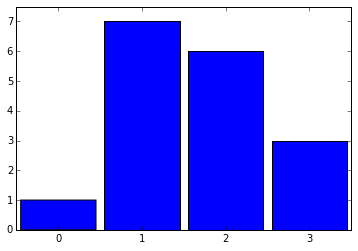

In [10]:
data = [info['trust_level'] for info in activity_info]
m = min(data)
M = max(data)
bins = np.ndarray.flatten(np.array([(i-0.45,i+0.45) for i in range(m,M+1)]))
hist_info = plt.hist(data, bins = bins)
ax = plt.gca()
ax.set_xlim(m-0.5,M+0.5)
ax.set_ylim(0,max(hist_info[0])+0.5)
ax.set_xticks([0,1,2,3]);

Since you get 10 points per user level, I got to assess Discourse grades by examining the (now supressed) output of the following.

In [ ]:
[(user['username'], user['trust_level']) for user in numerical_users]

And, since you get 10 points for doing the [Your favorite function](http://discourse.marksmath.org/t/your-favorite-function/50) question, I had to look at the output of the following, as well.

In [ ]:
response = requests.get("http://discourse.marksmath.org/t/50.json")
participants = response.json()['details']['participants']
[participant['username'] for participant in participants]